# Desafio Cientista de Dados -  Processo Seletivo Lighthouse

Você foi alocado(a) em um time da Indicium que está trabalhando atualmente junto a um cliente no processo de criação de uma plataforma de aluguéis temporários na cidade de Nova York. Para o desenvolvimento de sua estratégia de precificação, pediu para que a Indicium fizesse uma análise exploratória dos dados de seu maior concorrente, assim como um teste de validação de um modelo preditivo.

**Seu objetivo é desenvolver um modelo de previsão de preços a partir do dataset oferecido, e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema.** O uso de outras fontes de dados além do dataset é permitido (e encorajado).

**<span style="color:red">As entregas solicitadas serão respondidas ao longo deste jupyter notebook</span>**


In [1]:
# Import das bibliotecas que serão utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats
from collections import Counter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Printa a versão Python utilizada neste exercício
from platform import python_version
print('Versão Python:', python_version())

Versão Python: 3.11.5


In [3]:
# Printa a versão utilizada das bibliotecas importadas
# An IPython magic extension for printing date and time stamps, version numbers, and hardware information.
%reload_ext watermark
%watermark -a "Eduarda Martins Ribas" --iversions

Author: Eduarda Martins Ribas

numpy     : 1.24.3
scipy     : 1.11.1
pandas    : 2.0.3
sklearn   : 1.3.0
seaborn   : 0.12.2
plotly    : 5.9.0
matplotlib: 3.7.2



In [4]:
# Importa o dataset que será utilizado no projeto
df = pd.read_csv('teste_indicium_precificacao.csv')
df.head()

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimo_noites  numero_de_reviews ultima_review  \
0  Entire home/apt    225              1                 45    2019-05-21   
1     Private room    150              3                  0           NaN   
2  Entire home/apt     89              1                270    2019-07-05   
3  Entire home/apt     80             10                  9    2018-11-19   
4  Entire home/apt    200              3                 74    2019-06-22   

   reviews_por_mes  calculado_host_listings_count  disponibilidade_365  
0             0.38                              2                  355  
1              NaN                              1                  365  
2             4.64                              1                  194  
3             0.10                              1                    0  
4             0.59                              1                  129

In [5]:
# Lista as colunas que compõe o dataframe
df.columns

Index(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365'],
      dtype='object')

In [6]:
# Renomeando as colunas para ficarem padronizadas (em inglês)
df.rename(columns = {'nome': 'name', 
                     'bairro_group': 'borough', 
                     'bairro':'neighborhood', 
                     'minimo_noites': 'minimum_nights',
                     'numero_de_reviews': 'number_of_reviews', 
                     'ultima_review': 'last_review', 
                     'reviews_por_mes': 'reviews_per_month', 
                     'calculado_host_listings_count': 'calculated_host_listings_count',
                     'disponibilidade_365': 'availability_365'},
         inplace = True)

In [7]:
# Verifica se as colunas foram renomeadas com sucesso
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'borough', 'neighborhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

### Dicionário de dados:  
**id** - Atua como uma chave exclusiva para cada anúncio nos dados do aplicativo  
**name** - Representa o nome do anúncio  
**host_id** - Representa o id do usuário que hospedou o anúncio  
**host_name** - Contém o nome do usuário que hospedou o anúncio  
**borough** - Contém o nome do distrito onde o anúncio está localizado  
**neighborhood** - Contém o nome do bairro onde o anúncio está localizado  
**latitude** - Contém a latitude do local  
**longitude** - Contém a longitude do local  
**room_type** - Contém o tipo de espaço de cada anúncio  
**price** - Contém o preço por noite em dólares listado pelo anfitrião  
**minimum_nights** - Contém o número mínimo de noites que o usuário deve reservar  
**number_of_reviews** - Contém o número de comentários dados a cada listagem  
**last_review** - Contém a data da última revisão dada à listagem  
**reviews_per_month** - Contém o número de avaliações fornecidas por mês  
**calculated_host_listings_count** - Contém a quantidade de listagem por host  
**availability_365** - Contém o número de dias em que o anúncio está disponível para reserva  

In [8]:
# Vamos salvar do dataframe o dado que será utilizado para previsão após o treinamento dos modelos.
dado_previsao = df[0:1]
dado_previsao

id                   name  host_id host_name    borough neighborhood  \
0  2595  Skylit Midtown Castle     2845  Jennifer  Manhattan      Midtown   

   latitude  longitude        room_type  price  minimum_nights  \
0  40.75362  -73.98377  Entire home/apt    225               1   

   number_of_reviews last_review  reviews_per_month  \
0                 45  2019-05-21               0.38   

   calculated_host_listings_count  availability_365  
0                               2               355

In [9]:
# Exclui a primeira linha de registro do dataframe
df.drop([df.index[0]], inplace = True)

df.head()

id                                              name  host_id  \
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   
5  5121                                   BlissArtsSpace!     7356   

     host_name    borough        neighborhood  latitude  longitude  \
1    Elisabeth  Manhattan              Harlem  40.80902  -73.94190   
2  LisaRoxanne   Brooklyn        Clinton Hill  40.68514  -73.95976   
3        Laura  Manhattan         East Harlem  40.79851  -73.94399   
4        Chris  Manhattan         Murray Hill  40.74767  -73.97500   
5        Garon   Brooklyn  Bedford-Stuyvesant  40.68688  -73.95596   

         room_type  price  minimum_nights  number_of_reviews last_review  \
1     Private room    150               3                  0         NaN   
2  Entire home/apt     89               1                270  2019-07-05   
3  Entire home/apt     80              10                  9  2018-11-19   
4  Entire home/apt    200               3                 74  2019-06-22   
5     Private room     60              45                 49  2017-10-05   

   reviews_per_month  calculated_host_listings_count  availability_365  
1                NaN                               1               365  
2               4.64                               1               194  
3               0.10                               1                 0  
4               0.59                               1               129  
5               0.40                               1                 0

In [10]:
# Verifica a dimensão do dataframe
df.shape

(48893, 16)

In [11]:
# Verifica os nomes das colunas, a contagem de colunas não-nulas e o tipo de dado
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48893 entries, 1 to 48893
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48893 non-null  int64  
 1   name                            48877 non-null  object 
 2   host_id                         48893 non-null  int64  
 3   host_name                       48872 non-null  object 
 4   borough                         48893 non-null  object 
 5   neighborhood                    48893 non-null  object 
 6   latitude                        48893 non-null  float64
 7   longitude                       48893 non-null  float64
 8   room_type                       48893 non-null  object 
 9   price                           48893 non-null  int64  
 10  minimum_nights                  48893 non-null  int64  
 11  number_of_reviews               48893 non-null  int64  
 12  last_review                     

In [12]:
# Remove as colunas id, host_id e host_name que não trazem informação relevante para as análises que serão feitas.
# A coluna host_name também representa um problema legal segundo a LGPD, uma vez que identifica o anfitrião a quem pertence 
# o espaço.
df.drop(['id', 'host_id', 'host_name'], axis=1, inplace = True)

In [13]:
# Quantifica as colunas com valores faltantes
df.isna().sum()

name                                 16
borough                               0
neighborhood                          0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Verificamos a ausência de 10052 dados nas colunas last_review e reviews_per_month. Isso será tratados posteriormente.

## Análise exploratória e limpeza e normalização dos dados
Nossa variável de interesse é a coluna price, portanto iremos verificar como estão distribuídos os dados nessa coluna.

In [14]:
# Cria função que recebe como atributo um dataframe e uma coluna para plotar boxplot e histograma 
def boxplot_hist(dataframe, coluna):
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))    # Instancia a área de plotagem
    dataframe.boxplot(column = coluna, ax = ax[0])    # Cria o boxplot
    dataframe.hist(column = coluna, ax = ax[1]);     # Cria o histograma

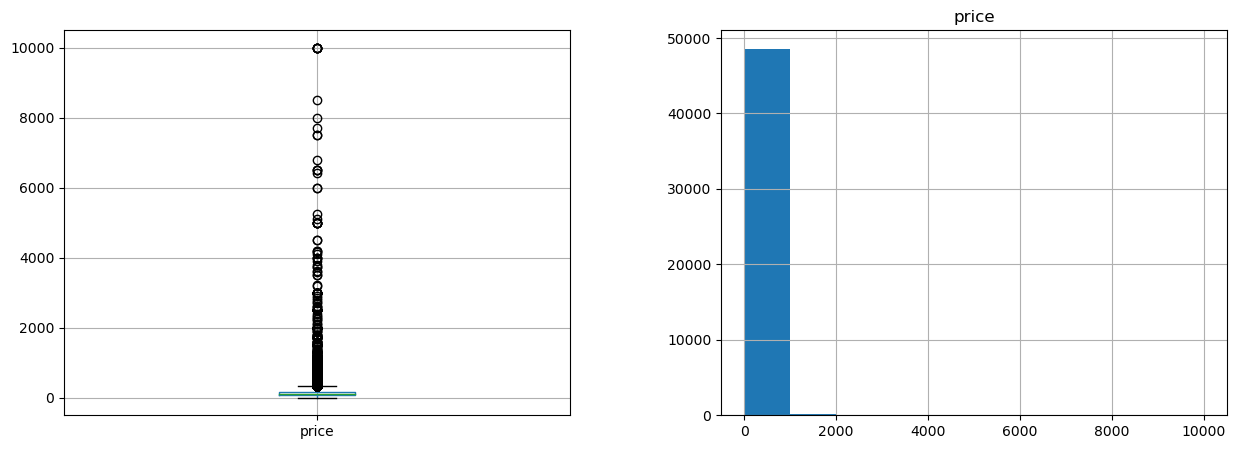

In [15]:
# Aplica a função para a coluna price do dataframe
boxplot_hist(df, 'price')

In [16]:
df['price'].describe()

count    48893.000000
mean       152.719285
std        240.158859
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Verificamos que existem alguns registros onde o valor de **locação é zero**. Neste caso, pode ter acontecido erro no registro da acomodação ou esta acomodação trabalha com alguma outra forma de pagamento, como por exemplo a troca de trabalho por acomodação. Nenhum dos dois casos são interessantes para essa análise, portanto iremos excluir esses registros.

In [17]:
# Quantifica quantos registros não possuem valor para locação
df[(df['price'] == 0)].value_counts().sum()

10

In [18]:
# Mantém somente os registros maior que zero.
df = df[(df['price'] > 0)]

A partir do boxplot é possível observar a existência de valores muito altos de preço, o que pode indicar a existência de espaços de alto luxo. Valores anômalos presentes em um conjunto de dados que serão utilizados na criação de modelos de *Machine Learning* de classificação ou regressão podem levar a um desempenho de modelagem preditiva inferior. Iremos então filtrar nosso dataset removendo os outliers.

In [19]:
print(f'Número de linhas antes de filtrar valores extremos (outliers): {len(df)}')

Número de linhas antes de filtrar valores extremos (outliers): 48882


In [20]:
# Calcula os limites superior e inferior para tratamento de outliers
limite_superior = df.price.mean() + 3 * df.price.std()
print("Valor superior:", limite_superior)

limite_inferior = df.price.mean() - 3 * df.price.std()
print("Valor inferior:", limite_inferior)

Valor superior: 873.2785032469521
Valor inferior: -567.7711999451233


In [21]:
# Extrai os registros com outliers na coluna preco e armazena no dataframe df_outliers_price para posterior análise 
#caso haja interesse
df_outliers_price = df[(df.price <= limite_inferior) | (df.price >= limite_superior)]
df_outliers_price.head()

name    borough  \
495              Luxury 2Bed/2.5Bath Central Park View  Manhattan   
761          6 Bedroom Landmark West Village Townhouse  Manhattan   
945                   Beautiful 3 bedroom in Manhattan  Manhattan   
1104  $ (Phone number hidden by Airbnb) weeks - room f  Manhattan   
1413               Luxury 1Bed with Central Park Views  Manhattan   

         neighborhood  latitude  longitude        room_type  price  \
495   Upper West Side  40.77350  -73.98697  Entire home/apt   2000   
761      West Village  40.73301  -74.00268  Entire home/apt   1300   
945   Upper West Side  40.80142  -73.96931     Private room   3000   
1104  Lower East Side  40.72152  -73.99279     Private room   1300   
1413  Upper West Side  40.77428  -73.98594  Entire home/apt   1000   

      minimum_nights  number_of_reviews last_review  reviews_per_month  \
495               30                 30  2018-05-05               0.33   
761                5                 28  2018-09-25               0.31   
945                7                  0         NaN                NaN   
1104               1                  0         NaN                NaN   
1413              30                 44  2015-09-28               0.53   

      calculated_host_listings_count  availability_365  
495                               11                 0  
761                                4               297  
945                                1               365  
1104                               1                 0  
1413                              11               364

In [22]:
# Verifica o tamanho do dataframe de outliers de preço
df_outliers_price.shape

(388, 13)

In [23]:
# Filtra o dataframe removendo os registros com outliers na coluna preco
df_sem_outliers = df[(df.price > limite_inferior) & (df.price < limite_superior)]

In [24]:
print(f'Número de linhas depois de filtrar valores extremos (outliers): {len(df_sem_outliers)}')

Número de linhas depois de filtrar valores extremos (outliers): 48494


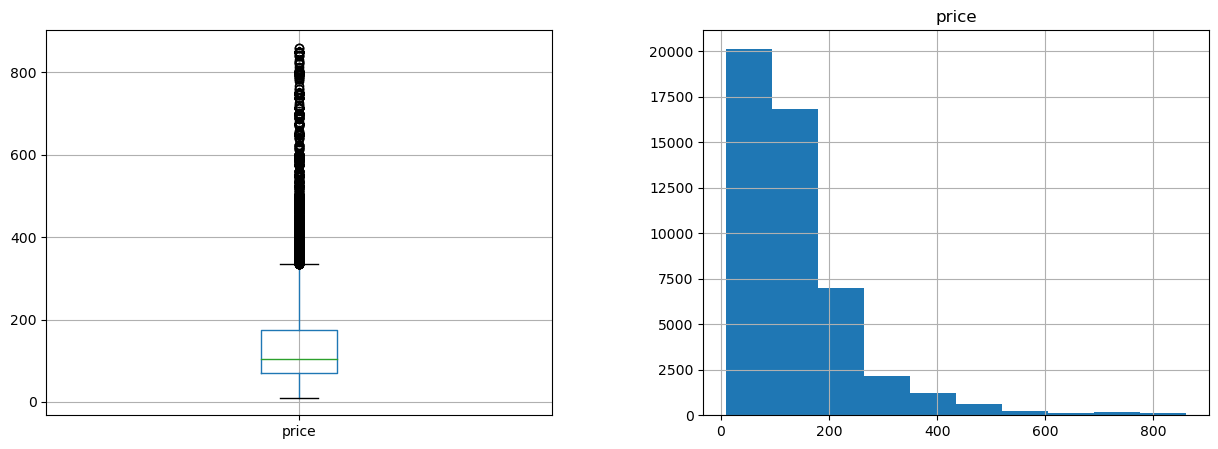

In [25]:
# Vamos verificar novamente a distribuição do preços no dataframe, agora sem a presença dos outliers iniciais
boxplot_hist(df_sem_outliers, 'price')

In [26]:
df_sem_outliers['price'].describe()

count    48494.000000
mean       138.776385
std        107.551623
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max        860.000000
Name: price, dtype: float64

Após a exclusão dos registros onde o preço aparecia como zero e dos valores outliers (3 desvios-padrão acima da média), podemos verificar que a maior parte dos espaços se encontra disponível por até 200 dólares, sendo a média de preço de 138 dólares.  
Com o novo histograma podemos observar também que a distribuição da variável preço apresenta uma assimetria positiva (a cauda mais longa da curva se apresenta a direta da média). Levando em consideração que o modelo de regressão pressupõe uma distribuição normal precisamos normalizar os dados da coluna price. **Iremos aplicar uma transformação logarítmica.** 

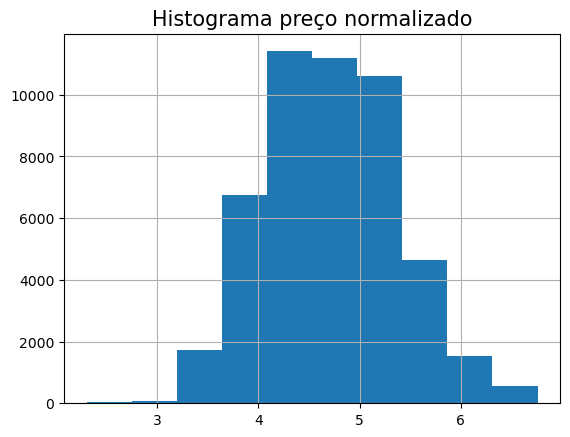

In [27]:
 # Aplica a normalização a coluna price e armazena na variável target_normalizado que usaremos posteriormente
target_normalizado = np.log(df_sem_outliers['price'])   

target_normalizado.hist()
plt.title('Histograma preço normalizado', fontsize = 15);

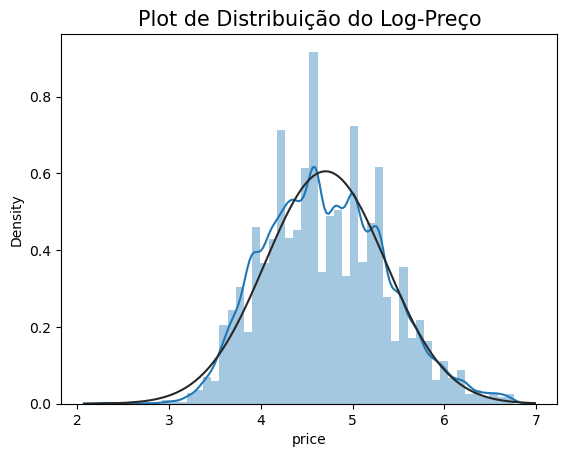

In [28]:
sns.distplot(target_normalizado, fit = stats.norm)
plt.title("Plot de Distribuição do Log-Preço",size=15);

É possível verificar que após a normalização os dados de preço tendem a uma distribuição normal. 

### Existe diferença a respeito de onde estão localizados os imóveis mais caros?

In [29]:
# Cria um gráfico mostrando as localizações dos espaços, incluindo uma faixa de cor com a informação do preço
fig = px.scatter_mapbox(df_sem_outliers, lat = "latitude", lon = "longitude", color = "price",
                  color_continuous_scale = px.colors.diverging.Portland, size_max = 15, zoom = 9,
                  mapbox_style = "carto-positron")
fig.show()

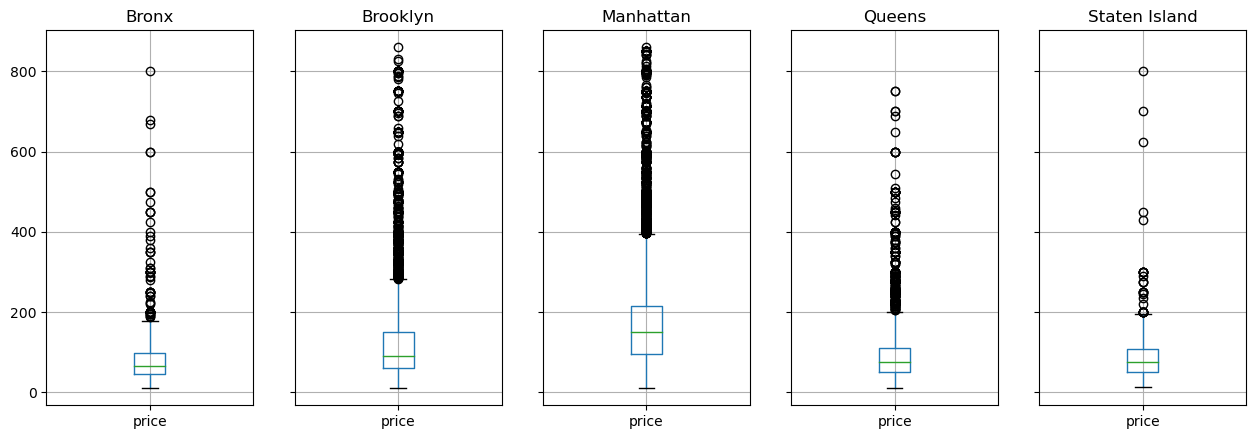

In [30]:
# Plota os boxplot do preço dos imóveis agrupados por bairro
df_sem_outliers.groupby('borough').boxplot(column = 'price', figsize = (15, 5), layout = (1, 5));

In [31]:
# Calcula as métricas de preço por área
media_preco_distrito = df_sem_outliers.groupby('borough')['price'].describe()
media_preco_distrito

count        mean         std   min   25%    50%    75%  \
borough                                                                    
Bronx           1088.0   84.521140   72.677670  10.0  45.0   65.0   99.0   
Brooklyn       20010.0  116.575162   88.432058  10.0  60.0   90.0  149.0   
Manhattan      21376.0  174.865597  121.629611  10.0  95.0  149.0  215.0   
Queens          5650.0   94.104779   69.190842  10.0  50.0   75.0  110.0   
Staten Island    370.0   96.148649   84.022175  13.0  50.0   75.0  109.0   

                 max  
borough               
Bronx          800.0  
Brooklyn       860.0  
Manhattan      860.0  
Queens         750.0  
Staten Island  800.0

Verificamos que os espaços mais caros se concentram na região de Manhattan e Brooklyn. Queens e Staten Island tem média de aluguel similares. O distrito com a média de aluguel mais baixo é o Bronx.  
  
Vamos verificar quais são os 10 bairros com valores mais altos e os 10 bairros com valores mais baixos:

In [32]:
# Cria dois dataframes distintos contendo os bairros mais caros e mais baratos
top10_bairros_caros = pd.DataFrame(df_sem_outliers.groupby(['neighborhood']).mean('price').nlargest(10, 'price')['price']).reset_index(level = 'neighborhood')

top10_bairros_baratos = pd.DataFrame(df_sem_outliers.groupby(['neighborhood']).mean('price').nsmallest(10, 'price')['price']).reset_index()

In [33]:
# Cria a lista de bairros por distrito
manhattan = df_sem_outliers[(df_sem_outliers['borough'] == 'Manhattan')]['neighborhood'].unique().tolist()
brooklyn = df_sem_outliers[(df_sem_outliers['borough'] == 'Brooklyn')]['neighborhood'].unique().tolist()
queens = df_sem_outliers[(df_sem_outliers['borough'] == 'Queens')]['neighborhood'].unique().tolist()
staten_island = df_sem_outliers[(df_sem_outliers['borough'] == 'Staten Island')]['neighborhood'].unique().tolist()
bronx = df_sem_outliers[(df_sem_outliers['borough'] == 'Bronx')]['neighborhood'].unique().tolist()

In [34]:
# Lista as condições
conditions = [(top10_bairros_caros['neighborhood'].isin(manhattan)),
            (top10_bairros_caros['neighborhood'].isin(brooklyn)),
            (top10_bairros_caros['neighborhood'].isin(queens)), 
            (top10_bairros_caros['neighborhood'].isin(staten_island)),
            (top10_bairros_caros['neighborhood'].isin(bronx))]

# lista os valores de retorno
choices  = ['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx']

# Cria uma nova coluna no dataframe baseada nas condições
top10_bairros_caros['borough'] = np.select(conditions, choices, "ERROR")
top10_bairros_baratos['borough'] = np.select(conditions, choices, "ERROR")

In [35]:
# Verifica o dataframe dos bairros mais caros
top10_bairros_caros

neighborhood       price        borough
0     Fort Wadsworth  800.000000  Staten Island
1            Woodrow  700.000000  Staten Island
2            Tribeca  305.792453      Manhattan
3               NoHo  276.246753      Manhattan
4           Neponsit  274.666667         Queens
5  Flatiron District  266.053333      Manhattan
6            Midtown  258.369781      Manhattan
7        Willowbrook  249.000000  Staten Island
8               SoHo  238.526316      Manhattan
9          Riverdale  236.300000          Bronx

In [36]:
# Verifica o dataframe dos bairros mais baratos
top10_bairros_baratos

neighborhood      price        borough
0     Bull's Head  47.333333  Staten Island
1     Hunts Point  50.500000  Staten Island
2         Tremont  51.545455      Manhattan
3       Soundview  53.466667      Manhattan
4        New Dorp  57.000000         Queens
5       Bronxdale  57.105263      Manhattan
6  New Dorp Beach  57.400000      Manhattan
7      Grant City  57.666667  Staten Island
8         Concord  58.192308      Manhattan
9      Mount Eden  58.500000          Bronx

<span style="color:red">**a. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?**</span>   
  
Seria indicada a compra de um apartamento no distrito de Manhattan, pois este demonstrou a média de aluguel mais cara comparada com os outros distritos. Além disso, é interessante observar a possibilidade de compra nos bairros Tribeca, NoHo, Flatiron District, Midtown ou SoHo, que configuraram entre os dez bairros de valor de locação mais alto, possuindo também uma boa taxa de ocupação, tendo seus anúncios disponíveis para reserva somente 1/3 do ano, conforme análises realizadas abaixo.

In [37]:
# Cria o dataframe agrupado por bairros contendo as informações de disponibilidade
df_avaiability = pd.DataFrame(df_sem_outliers.groupby('neighborhood')['availability_365'].mean()).reset_index()

# Seleciona somente os bairros de interesse
df_avaiability = df_avaiability[df_avaiability['neighborhood'].isin(['Tribeca', 'NoHo', 'Flatiron District', 'Midtown', 'SoHo'])]

df_avaiability

neighborhood  availability_365
75   Flatiron District        119.186667
127            Midtown        156.135852
144               NoHo        101.636364
178               SoHo        105.616959
197            Tribeca        119.981132

In [38]:
# Média de disponibilidade dos bairros selecionados
df_avaiability['availability_365'].mean()

120.51139460003044

### Como é a divisão de acomodação pelos distritos

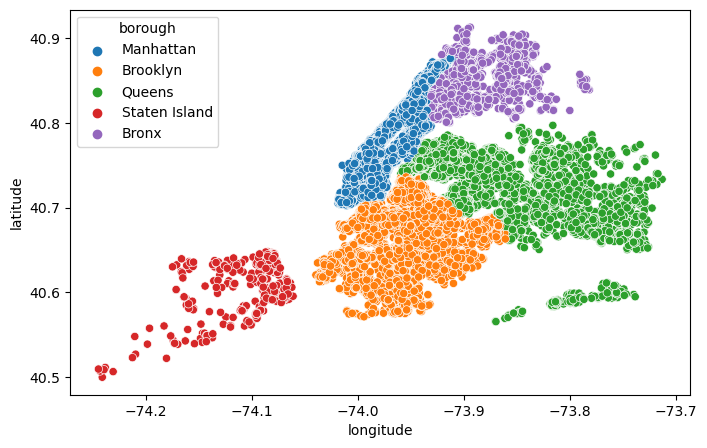

In [39]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.scatterplot(y = df_sem_outliers['latitude'], x = df_sem_outliers['longitude'], hue = df_sem_outliers['borough'])
plt.show();

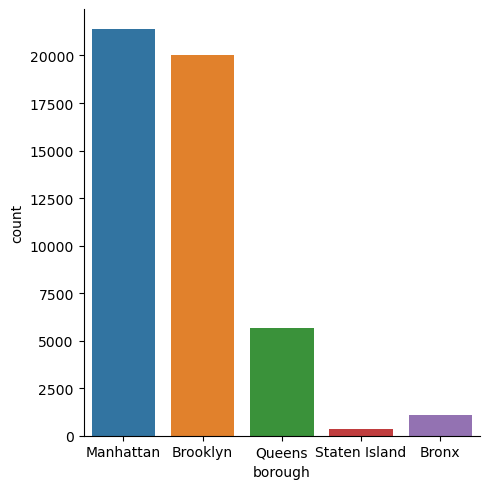

In [40]:
sns.catplot(x = 'borough', kind = 'count', data = df_sem_outliers);

A grande maioria das acomodações se encontra nos distritos de Manhattan. São poucas as propriedades para locação no Bronx e Staten Island.

### Como é a composição espaços para locação?

In [41]:
# Tabela de frequência dos tipos de acomodação (room_type)
room_freq = df_sem_outliers['room_type'].value_counts()
labels = room_freq.index.tolist()

room_freq

room_type
Entire home/apt    25099
Private room       22241
Shared room         1154
Name: count, dtype: int64

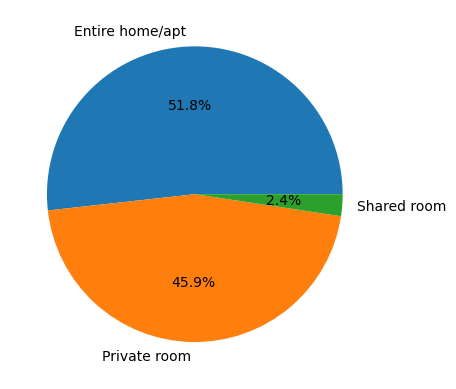

In [42]:
# Plot do gráfico de frequência de tipos de acomodação (room_type)
plt.pie(room_freq, labels = labels, autopct='%1.1f%%');

A maior parte das acomodações são de apartamento inteiro ou quarto privado. Poucas são as acomodações de quarto compartilhado.  

**Vamos verificar os 10 bairros com maior número de acomodações disponíveis.**

In [43]:
# Quantifica os bairros com maior número de acomodações
df_sem_outliers['neighborhood'].value_counts().head(10)

neighborhood
Williamsburg          3905
Bedford-Stuyvesant    3696
Harlem                2649
Bushwick              2459
Hell's Kitchen        1943
Upper West Side       1933
East Village          1838
Upper East Side       1776
Crown Heights         1560
Midtown               1509
Name: count, dtype: int64

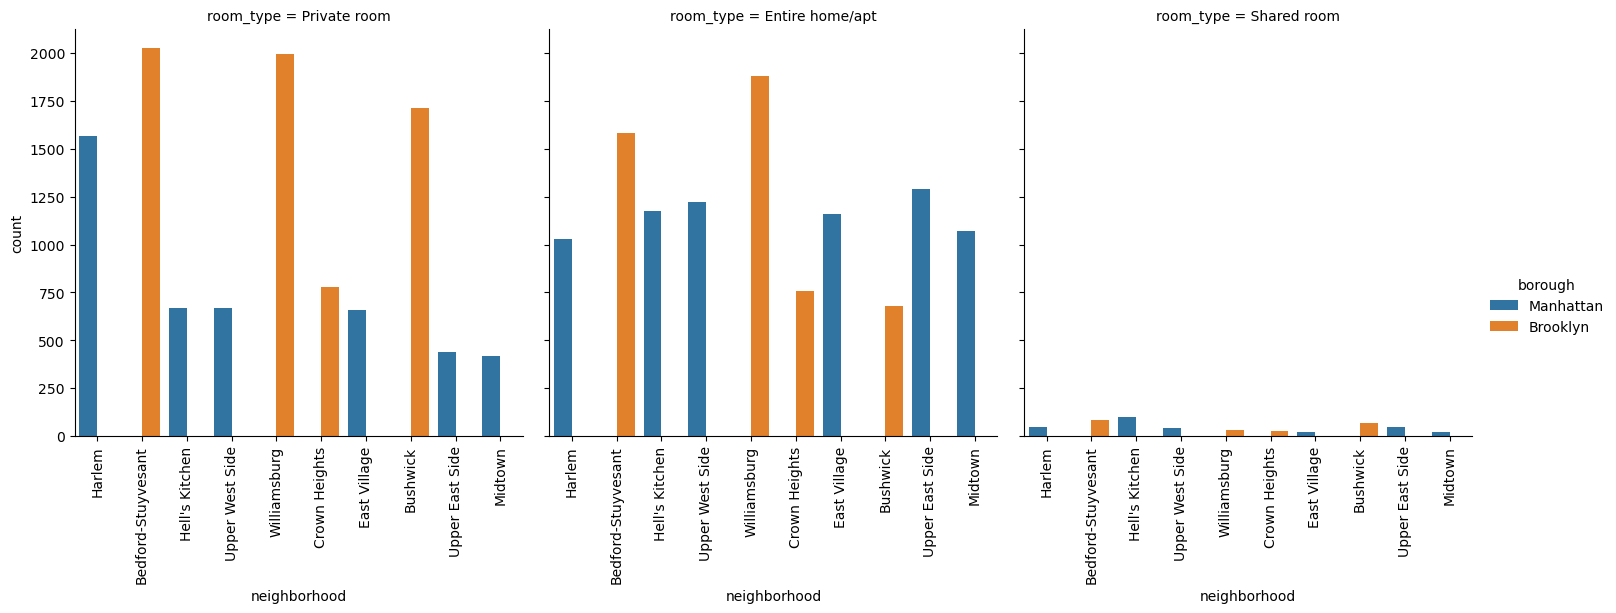

In [44]:
#grabbing top 10 neighbourhoods for sub-dataframe
top10_bairros = df_sem_outliers.loc[df_sem_outliers['neighborhood'].isin(['Williamsburg','Bedford-Stuyvesant','Harlem',
                                                                           'Bushwick', 'Hell\'s Kitchen', 'Upper West Side',
                                                                           'East Village','Upper East Side','Crown Heights','Midtown'])]

#using catplot to represent multiple interesting attributes together and a count
sns.catplot(x = 'neighborhood', hue = 'borough', col = 'room_type', data = top10_bairros, kind = 'count').set_xticklabels(rotation=90);

Corroborando com os dados anteriores a respeito das acomodações nos distritos, os bairros com maior número de acomodações pertencem aos distritos com maior quantidade de espaços para locação (Manhattan e Brooklyn). Também como visto anterioremente, os espaços se dividem preferencialmente entre casa ou apartamento inteiro e quarto privado.


### Existe um padrão no texto do nome do local para lugares de mais alto valor?

Para realizar essa avaliação vamos dividir categorizar os espaços em 2 categorias, espaços de preço médio (com valor até 200 doláres, onde se encontram distribuídos os preços da grande maioria dos espaços anunciados, e espaços de alto valor com preços a partir de 200 doláres.

In [45]:
# Cria dataframe contendo somente as variáveis name e price
df_name = df_sem_outliers[['name', 'price']]

df_name_mean_price = df_name[(df_name['price'] <= 200)]
df_name_high_value = df_name[(df_name['price'] > 200)]

print(df_name_mean_price.shape)
print(df_name_high_value.shape)

(40499, 2)
(7995, 2)


In [46]:
# Criando o dataframe como imóveis de preço médio
# inicializa uma lista vazia onde colocaremos nossas strings de nome
nomes = []

# obtém as strings de nome da coluna e anexa-as à lista de strings
for nome in df_name_mean_price['name']:
    nomes.append(nome)
    
# define uma função que irá fazer o split dos strings de nome e separar em palavras
def split_name(nome):
    split = str(nome).split()
    return split

# inicializa uma lista vazia onde iremos armazenar as palavras para contagem
contagem_nomes = []

# obtém a string de nome da nossa lista e usa a função split para posteriormente anexar à lista acima
for i in nomes:
    for palavra in split_name(i):
        palavra = palavra.lower()
        contagem_nomes.append(palavra)
        
top_25_palavras = Counter(contagem_nomes).most_common()
top_25_palavras = top_25_palavras[0:25]

df_palavras_mean_price = pd.DataFrame(top_25_palavras)
df_palavras_mean_price.rename(columns = {0:'palavras', 1:'quantidade'}, inplace = True)

In [47]:
# Repete o processo acima para criar o dataframe de imóveis de alto valor.
nomes = []

for nome in df_name_high_value['name']:
    nomes.append(nome)
    
def split_name(nome):
    split = str(nome).split()
    return split

contagem_nomes = []

for i in nomes:
    for palavra in split_name(i):
        palavra = palavra.lower()
        contagem_nomes.append(palavra)
        
top_25_palavras = Counter(contagem_nomes).most_common()
top_25_palavras = top_25_palavras[0:25]

df_palavras_high_value = pd.DataFrame(top_25_palavras)
df_palavras_high_value.rename(columns = {0:'palavras', 1:'quantidade'}, inplace = True)

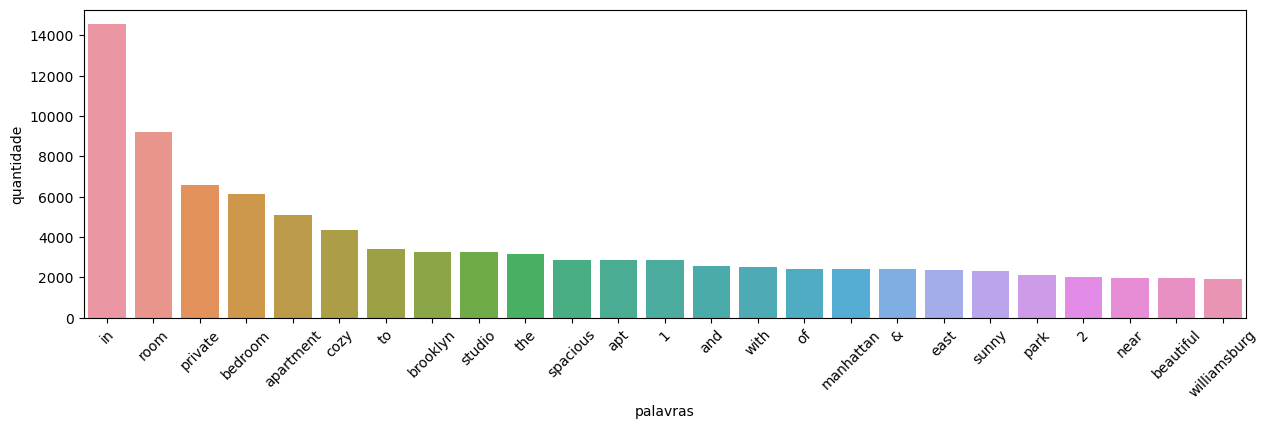

In [48]:
# Vamos plotar os dados em gráfico de barra para melhor visualização.
fig, ax = plt.subplots(figsize = (15, 4))

ax = sns.barplot(x = 'palavras', y = 'quantidade', data = df_palavras_mean_price)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

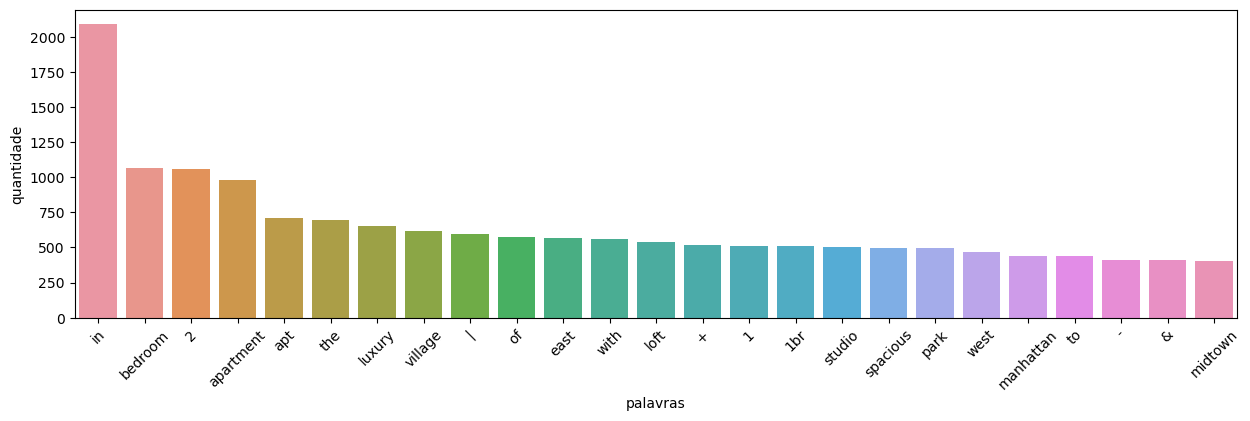

In [49]:
fig, ax1 = plt.subplots(figsize = (15, 4))

ax1 = sns.barplot(x = 'palavras', y = 'quantidade', data = df_palavras_high_value)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45);

**<span style="color:red">c. Existe algum padrão no texto do nome do local para lugares de mais alto valor?</span>**

De maneira geral as acomodações tendem a ser descrita de forma mais generalista, contudo é possível observar que os apartamentos de preço médio tendem a ser descritos utilizando palavras como “aconchegante”, “espaçoso”, “ensolarado” e “bonito”, enquanto apartamentos de preços mais altos tem a maior ocorrência do aparecimento dos nomes dos bairros (east, village, Manhattan, Midtown) e da palavra “luxo” na descrição.

### Mínimo de noites para locação

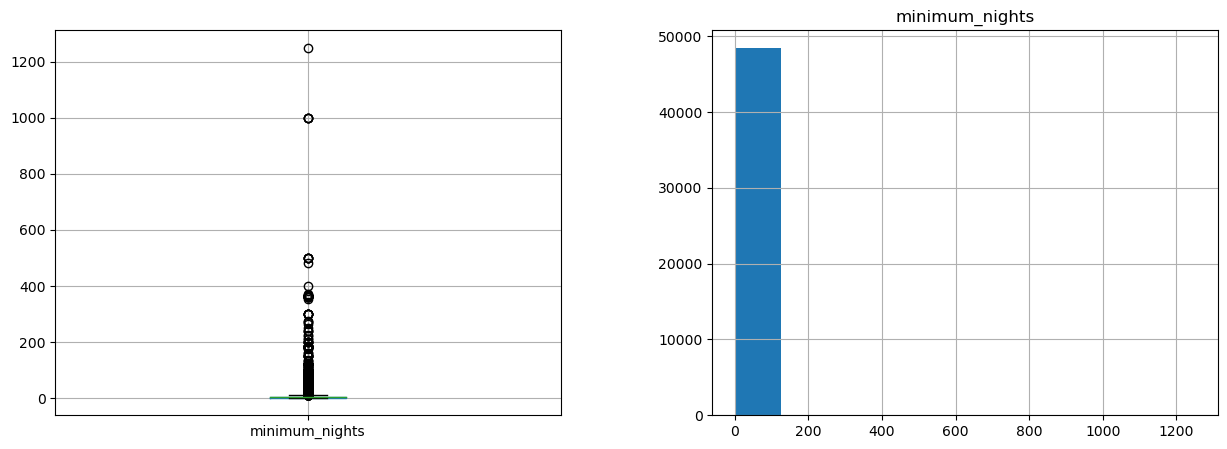

In [50]:
boxplot_hist(df_sem_outliers, 'minimum_nights')

In [51]:
# Quantifica as linhas onde o mínimo de noites para locação são acima de 30.
df_sem_outliers[(df_sem_outliers['minimum_nights'] > 30)].shape

(719, 13)

Na coluna de mínimo de noites disponível para locação temos um problema. Nosso dataset contém registros com números altos de mínimo de noite para locação. Como o intuito do projeto é precificar espaço para locação por temporada, períodos grandes de locação não fazem sentido, portanto iremos excluir registros com mínimo de noites acima de 30.

In [52]:
df_sem_outliers = df_sem_outliers[(df_sem_outliers['minimum_nights'] <= 30)]

In [53]:
# Dimensão do novo dataframe
df_sem_outliers.shape

(47775, 13)

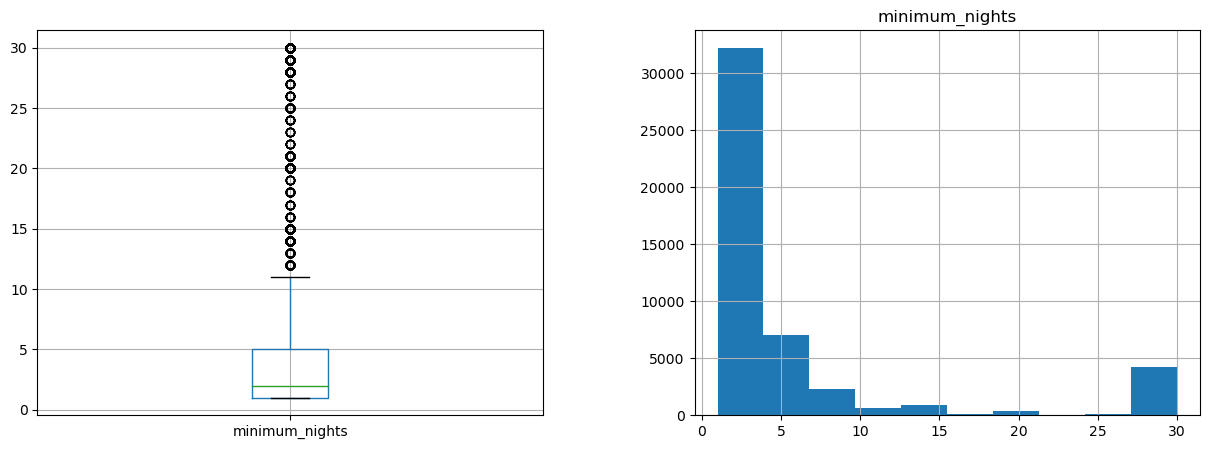

In [54]:
boxplot_hist(df_sem_outliers, 'minimum_nights')

Podemos verificar que a maior parte das acomodações exige como número mínimo de noites para locação entre 1 e 5 noites.

### O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Correlação entre minimum_nights e availability_365 é de 0.24.


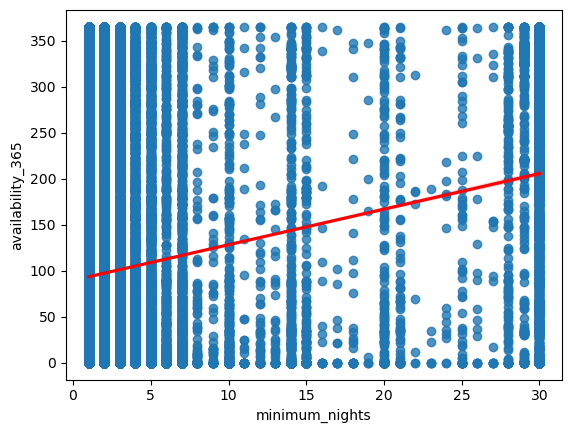

In [55]:
# Calcula a correlação
corr = df_sem_outliers['minimum_nights'].corr(df_sem_outliers['availability_365'])
print('Correlação entre minimum_nights e availability_365 é de {:.2f}.'.format(corr))

# Cria o plot o scatter plot com a linha de correlação
sns.regplot(x = df_sem_outliers['minimum_nights'], y = df_sem_outliers['availability_365'], line_kws = dict(color = 'r'));

**<span style="color:red">b. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?</span>**

Existe uma fraca correlação positiva (0.24) entre o número mínimo de noites e a disponibilidade ao longo do ano. Isto implica que quando maior o número mínimo de noites, maior a disponibilidade do anuncio para reserva, o que pode significar uma menor taxa de ocupação da acomodação.

### Número de avaliações e avaliações por mês

In [56]:
# Calculando valores not a number na coluna reviews_per_month - True = registro vazio
df_sem_outliers['reviews_per_month'].isna().value_counts()

reviews_per_month
False    38204
True      9571
Name: count, dtype: int64

In [57]:
# Onde houver valor NaN na coluna reviews_per_month será substituído por zero.
df_sem_outliers['reviews_per_month'].fillna(0, inplace = True)

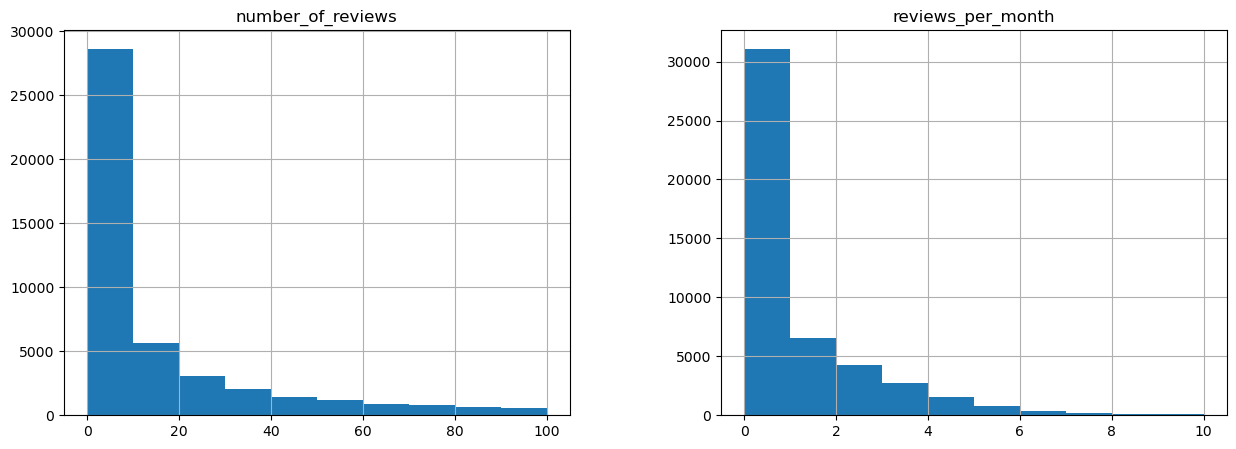

In [58]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

# indica os plots que serão efetuados
df_sem_outliers.hist(column = 'number_of_reviews', bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], ax = ax[0] );
df_sem_outliers.hist(column = 'reviews_per_month', bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ax = ax[1]);

Podemos verificar que os gráficos number_of_reviews e reviews_per_month são semelhantes em sua distribuição dos dados.  
A maioria dos espaços possuem até 10 reviews e nenhum review por mês, o que pode sugerir que são acomodações pouco alugadas ou novas na plataforma.

**Vamos verificar as dez acomodações com maior número de reviews**

In [59]:
top10_reviews = df_sem_outliers.nlargest(10, 'number_of_reviews')
top10_reviews

name    borough  \
11758                            Room near JFK Queen Bed     Queens   
2030                          Great Bedroom in Manhattan  Manhattan   
2029                      Beautiful Bedroom in Manhattan  Manhattan   
2014                        Private Bedroom in Manhattan  Manhattan   
13494                            Room Near JFK Twin Beds     Queens   
10622                  Steps away from Laguardia airport     Queens   
1878            Manhattan Lux Loft.Like.Love.Lots.Look !  Manhattan   
20402  Cozy Room Family Home LGA Airport NO CLEANING FEE     Queens   
4869                  Private brownstone studio Brooklyn   Brooklyn   
470                      LG Private Room/Family Friendly   Brooklyn   

          neighborhood  latitude  longitude        room_type  price  \
11758          Jamaica  40.66730  -73.76831     Private room     47   
2030            Harlem  40.82085  -73.94025     Private room     49   
2029            Harlem  40.82124  -73.93838     Private room     49   
2014            Harlem  40.82264  -73.94041     Private room     49   
13494          Jamaica  40.66939  -73.76975     Private room     47   
10622    East Elmhurst  40.77006  -73.87683     Private room     46   
1878   Lower East Side  40.71921  -73.99116     Private room     99   
20402    East Elmhurst  40.76335  -73.87007     Private room     48   
4869        Park Slope  40.67926  -73.97711  Entire home/apt    160   
470           Bushwick  40.70283  -73.92131     Private room     60   

       minimum_nights  number_of_reviews last_review  reviews_per_month  \
11758               1                629  2019-07-05              14.58   
2030                1                607  2019-06-21               7.75   
2029                1                597  2019-06-23               7.72   
2014                1                594  2019-06-15               7.57   
13494               1                576  2019-06-27              13.40   
10622               1                543  2019-07-01              11.59   
1878                2                540  2019-07-06               6.95   
20402               1                510  2019-07-06              16.22   
4869                1                488  2019-07-01               8.14   
470                 3                480  2019-07-07               6.70   

       calculated_host_listings_count  availability_365  
11758                               2               333  
2030                                3               293  
2029                                3               342  
2014                                3               339  
13494                               2               173  
10622                               5               163  
1878                                1               179  
20402                               5               341  
4869                                1               269  
470                                 1                 0

In [60]:
# Média do valor de locação dos imóveis com mais reviews
top10_reviews['price'].mean()

65.4

O distrito de Queens aparece como terceiro em número de acomodações. É possível que a baixa quantidade de acomodações disponíveis em comparação com Manhattan e Brooklyn favoreça o aparecimento de quatro acomodações no distrito de Queens na lista de mais avaliadas do dataset.  
Outra informação interessante a ser observada é que a média de preço das acomodações mais avaliadas gira em torno de 47% do valor médio de aluguel dos imóveis, sugerindo uma predileção por acomodações com preços mais baixos, o que pode justificar também a predominância de quartos privados na lista de acomodações mais avaliadas. 

### Contagem calculada de listagens de anfitriões - calculated_host_listings_count
É o número real de anúncios por anfitrião, uma métrica para medir a experiência do anfitrião ou para distinguir empresas de indivíduos.

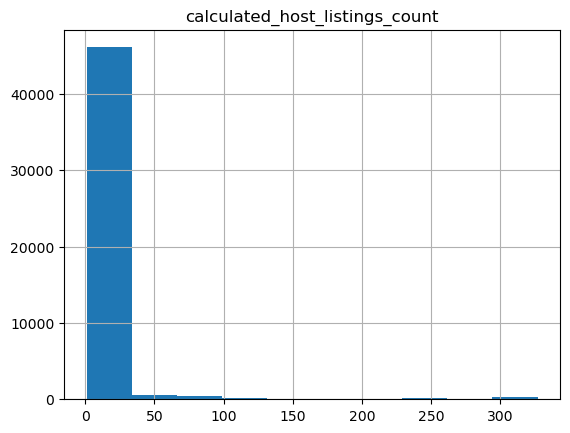

In [61]:
df_sem_outliers.hist(column = 'calculated_host_listings_count');

In [62]:
# # Quantifica a quantidade de registros e retorna em percentual
df_sem_outliers['calculated_host_listings_count'].value_counts(normalize = True).sort_values(ascending = False).head(5) * 100

calculated_host_listings_count
1    66.078493
2    13.682889
3     5.885924
4     2.945055
5     1.716379
Name: proportion, dtype: float64

Observamos que 82% dos anfitriões possuem até 3 imóveis anunciados na plataforma.

### Disponibilidade de locação do espaço (availability_365)

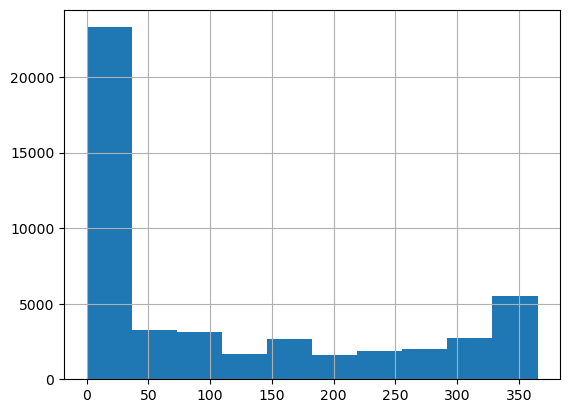

In [63]:
df_sem_outliers['availability_365'].hist();

In [64]:
df_sem_outliers['availability_365'].describe()

count    47775.000000
mean       111.165735
std        130.918389
min          0.000000
25%          0.000000
50%         42.000000
75%        222.000000
max        365.000000
Name: availability_365, dtype: float64

In [65]:
# Quantifica a quantidade de registros por dia ocupado e retorna em percentual
df_sem_outliers['availability_365'].value_counts(normalize = True).head(10) * 100

availability_365
0      36.198849
365     2.432234
364     0.967033
1       0.843537
89      0.730508
5       0.707483
3       0.636316
179     0.604919
2       0.554683
90      0.550497
Name: proportion, dtype: float64

availabilty_365 é um indicador do número total de dias que o anúncio está disponível durante o ano (ou seja, se todos os dias disponíveis forem alugados, a taxa de ocupação do anúncio é de 100%, logo o indicador será 0). Podemos verificar que aproximadamente 36% dos anuncios fica sempre indisponível. 

### Criação do modelo


**<span style="color:red">3.	Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?</span>**

O desafio proposto se trata de um problema de **regressão**, onde utilizaremos variáveis independentes (features) para tentar prever o comportamento (valor) de uma variável dependente ou de saída (neste caso, o preço).  

Inicialmente haviam 16 colunas compondo o dataframe:  id, name, host_id, host_name, borough, neighborhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, availability_365.

**Remoção e tratamento das colunas:**  
- **id, name, host_id, host_name:** Colunas removidas. Não trazem informação relevante para criação do modelo. A coluna host_name também representa um problema legal segundo a LGPD, uma vez que identifica o anfitrião a quem pertence o imóvel/quarto.  
- **borough e room_type:** Submetidas a codificação one hot encoding. Variáveis categorias nominais são melhores codificadas através de uma transformação em uma variável binária. Isto evita inferir uma ordem de categorização nessas variáveis durante o treinamento de modelo.  
- **neighborhood:** Submetida a codificação Label Encoding, onde cada bairro irá receber um número que o representará no dataset final. Apesar desse tipo de codificação inferir que há uma ordem entre os bairros, optamos por essa abordagem afim de não aumentar a dimensionalidade do modelo que será criado (o dataset possui em torno de 200 bairros, o que implicaria na criação de 200 novas colunas, caso optássemos pela utilização do one hot encoding).   
- **latitude, longitude:** Dados incluídos na análise sem alteração.  
- **minimum_nights:** Foram excluídos registros que exibiam mais que 30 como valor mínimo de noites para reservar. Como o intuito do modelo que será criado é a precificação do aluguel de imóveis/espaços para locação por temporada, não era coerente manter estes dados.  
- **number_of_reviews, calculated_host_listings_count e availability_365:** Dados foram normalizados por Standard Scaler. Como os dados desta coluna apresentavam uma faixa de variação muito grande, cada valor foi transformado de forma que a média dos dados padronizados seja zero e o desvio padrão seja igual a um. Esse procedimento auxilia na melhora do desempenho uma vez que algoritmos de aprendizado de máquina convergem mais rapidamente em dados normalizados. Um outro fator que levou a essa decisão é que alguns algoritmos de regressão são sensíveis a escala das features e a não normalização pode levar a resultados distorcidos.  
- **last_review:** Coluna removida.
- **price:** Variável alvo foi normalizada através de uma transformação logarítmica, pois os dados apresentavam uma assimetria positiva. A transformação logarítmica auxilia na redução da assimetria e melhora a qualidade do modelo.

Neste desafio optamos por utilizar a **regressão linear múltipla** como modelo baseline para comparação. Este algoritmo apresenta uma série de pontos positivos como simplicidade interpretativa, facilidade de implementação, eficiência computacional (pode lidar com grandes conjuntos de dados e ser treinado rapidamente em comparação com modelos mais complexos) e estabilidade (é estável para pequenos a moderados conjuntos de dados, o que significa que pequenas alterações nos dados de treinamento não resultam em grandes mudanças nos parâmetros do modelo).  
Após a criação do modelo de regressão linear, utilizaremos também o **Random Forest Regressor** como segundo modelo, afim de verificar se este modelo melhor se aproxima dos dados. O Random Forest Regressor é um modelo mais complexo e por isso é capaz de capturar relações não lineares entre as variáveis. 

Utilizares como medida de avaliação de performance dos modelos criados o R²ajustado, o erro quadrático médio (MSE), a raiz do erro quadrático médio (RMSE) e o erro percentual absoluto médio (MAPE).  
O **R²ajustado** é uma versão ajustada do R², que leva em consideração o número de variáveis independentes no modelo, penalizando variáveis excessivas, fornecendo uma métrica mais precisa da qualidade de ajuste do modelo. Neste sentido o R² ajustado se torna mais adequado ao modelo de regressão com múltiplas variáveis de entrada.  
**Erro quadrático médio (MSE)** consiste na média do erro das previsões ao quadrado. Esta métrica assume o valor mínimo de 0, sem valor máximo, o que a torna uma boa métrica de comparação entre dois modelos distintos.  
**Raiz do erro quadrático médio (RMSE)** surge como forma de melhorar a interpretabilidade do MSE, uma vez que expressa o erro do modelo na unidade de medida da variável de saída.  
**Erro percentual absoluto médio (MAPE)** essa medida exprime em porcentagem a diferença entre o valor predito e o valor real. Por ser expresso como um valor percentual, é uma métrica útil para comparar a precisão de diferentes modelos independentemente da escala das variáveis.  

In [66]:
# Após a exclusão de diversas linhas durante a análise exploratória e limpeza de dados é necessário resetar o index do dataframe
# se não poderá resultar em erros de concatenação nas próximas etapas.
df_sem_outliers.reset_index(inplace = True)

In [67]:
# Verificando as colunas que compõe o dataframe
df_sem_outliers.columns

Index(['index', 'name', 'borough', 'neighborhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [68]:
df_sem_outliers.shape

(47775, 14)

In [69]:
# Separando variáveis que irão passar por One hot encoding
variaveis_cat1 = df_sem_outliers[['room_type', 'borough']]

Para encerrar a etapa de tratamento e limpeza de dados iremos converter as variáveis categóricas room_type e borough em variável binária utilizando o one hot encoding e a variável neighborhood utilizando o label encoding.

In [70]:
# Cria o one hot encoding
variaveis_cat_encoded = pd.get_dummies(variaveis_cat1)

# Visualiza a transformação
variaveis_cat_encoded

room_type_Entire home/apt  room_type_Private room  \
0                          False                    True   
1                           True                   False   
2                           True                   False   
3                           True                   False   
4                          False                    True   
...                          ...                     ...   
47770                      False                    True   
47771                      False                    True   
47772                       True                   False   
47773                      False                   False   
47774                      False                    True   

       room_type_Shared room  borough_Bronx  borough_Brooklyn  \
0                      False          False             False   
1                      False          False              True   
2                      False          False             False   
3                      False          False             False   
4                      False          False             False   
...                      ...            ...               ...   
47770                  False          False              True   
47771                  False          False              True   
47772                  False          False             False   
47773                   True          False             False   
47774                  False          False             False   

       borough_Manhattan  borough_Queens  borough_Staten Island  
0                   True           False                  False  
1                  False           False                  False  
2                   True           False                  False  
3                   True           False                  False  
4                   True           False                  False  
...                  ...             ...                    ...  
47770              False           False                  False  
47771              False           False                  False  
47772               True           False                  False  
47773               True           False                  False  
47774               True           False                  False  

[47775 rows x 8 columns]

In [71]:
# Label Encoder
label_encoder = LabelEncoder()     # Instância o encoder

# Realiza o fit e transforma os dados
neighborhood_encoded = label_encoder.fit_transform(df_sem_outliers['neighborhood']).reshape(-1,1) 
neighborhood_encoded

array([[94],
       [41],
       [61],
       ...,
       [94],
       [95],
       [95]])

In [72]:
# Concatena os dataframes de variáveis categóricas codificados
cat_concat = pd.concat([variaveis_cat_encoded, pd.DataFrame(neighborhood_encoded, columns = ['neighborhood'])], axis = 1)
cat_concat

room_type_Entire home/apt  room_type_Private room  \
0                          False                    True   
1                           True                   False   
2                           True                   False   
3                           True                   False   
4                          False                    True   
...                          ...                     ...   
47770                      False                    True   
47771                      False                    True   
47772                       True                   False   
47773                      False                   False   
47774                      False                    True   

       room_type_Shared room  borough_Bronx  borough_Brooklyn  \
0                      False          False             False   
1                      False          False              True   
2                      False          False             False   
3                      False          False             False   
4                      False          False             False   
...                      ...            ...               ...   
47770                  False          False              True   
47771                  False          False              True   
47772                  False          False             False   
47773                   True          False             False   
47774                  False          False             False   

       borough_Manhattan  borough_Queens  borough_Staten Island  neighborhood  
0                   True           False                  False            94  
1                  False           False                  False            41  
2                   True           False                  False            61  
3                   True           False                  False           137  
4                   True           False                  False            95  
...                  ...             ...                    ...           ...  
47770              False           False                  False            13  
47771              False           False                  False            28  
47772               True           False                  False            94  
47773               True           False                  False            95  
47774               True           False                  False            95  

[47775 rows x 9 columns]

In [73]:
# Lista as variáveis quantitativas
variaveis_quant = df_sem_outliers[['latitude', 'longitude','minimum_nights', 'number_of_reviews', 'reviews_per_month', 
                                   'calculated_host_listings_count', 'availability_365']]
# Instancia o standard scaler
scaler = StandardScaler()

# Treina e transforma as variáveis
variaveis_quant_norm = scaler.fit_transform(variaveis_quant[['number_of_reviews', 'calculated_host_listings_count', 'availability_365']])
label_variaveis_quant_norm = ['number_of_reviews', 'calculated_host_listings_count', 'availability_365']

variaveis_quant_norm.shape

(47775, 3)

In [74]:
# Remove do dataframe de variáveis quantitativas as colunas que foram normalizadas
variaveis_quant.drop(['number_of_reviews', 'calculated_host_listings_count', 'availability_365'], axis = 1, inplace = True)

In [75]:
# Concatena os dados quantitativas normalizados e não-normalizados
quant_concat = pd.concat([variaveis_quant, pd.DataFrame(variaveis_quant_norm, columns = label_variaveis_quant_norm)], axis=1)

In [76]:
# Concatena os dataframes de dados quantitativos e categóricos
df_features = pd.concat([quant_concat, cat_concat], axis = 1)
df_features.head()

latitude  longitude  minimum_nights  reviews_per_month  number_of_reviews  \
0  40.80902  -73.94190               3               0.00          -0.525899   
1  40.68514  -73.95976               1               4.64           5.495686   
2  40.79851  -73.94399              10               0.10          -0.325179   
3  40.74767  -73.97500               3               0.59           1.124461   
4  40.76489  -73.98493               2               3.47           9.064033   

   calculated_host_listings_count  availability_365  \
0                       -0.186153          1.938894   
1                       -0.186153          0.632723   
2                       -0.186153         -0.849131   
3                       -0.186153          0.136226   
4                       -0.186153          0.831323   

   room_type_Entire home/apt  room_type_Private room  room_type_Shared room  \
0                      False                    True                  False   
1                       True                   False                  False   
2                       True                   False                  False   
3                       True                   False                  False   
4                      False                    True                  False   

   borough_Bronx  borough_Brooklyn  borough_Manhattan  borough_Queens  \
0          False             False               True           False   
1          False              True              False           False   
2          False             False               True           False   
3          False             False               True           False   
4          False             False               True           False   

   borough_Staten Island  neighborhood  
0                  False            94  
1                  False            41  
2                  False            61  
3                  False           137  
4                  False            95

In [77]:
# Variável target normalizada
target_normalizado = np.log(df_sem_outliers['price'])

In [78]:
# Printa o formato dos dataframes gerados
print(df_features.shape)
print(target_normalizado.shape)

(47775, 16)
(47775,)


## Criando o modelo de Regressão

In [79]:
# Vamos separar os dados de treino (70%) e teste (30%)
X_treino, X_teste, y_treino, y_teste = train_test_split(df_features, target_normalizado, test_size = 0.3)

In [80]:
# Verifica o tamanho dos dados de treino
len(X_treino)

33442

In [81]:
# Verifica o tamanho dos dados de treino
len(X_teste)

14333

### Treinamento e Avaliação de Regressão Linear Múltipla (baseline)

In [82]:
modelo_lr = LinearRegression()       # Instancia o modelo
modelo_lr.fit(X_treino, y_treino)    # Treina o modelo

LinearRegression()

In [83]:
# Previsões com dados de teste
pred_lr = modelo_lr.predict(X_teste)

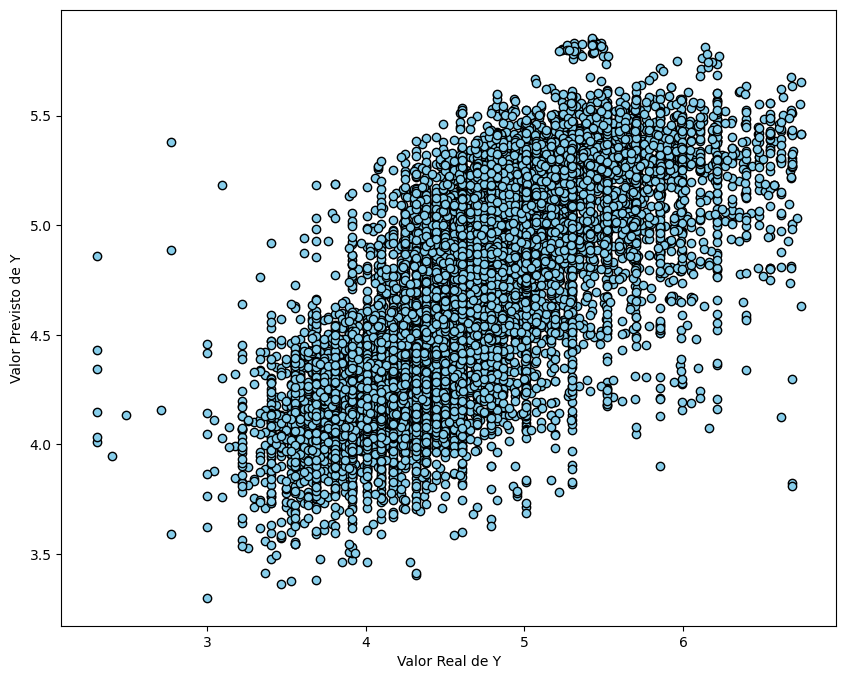

In [84]:
# Plot dos valores reais x valores previstos
plt.figure(figsize = (10,8))
plt.scatter(x = y_teste, y = pred_lr, color = 'skyblue', edgecolors = 'black')
plt.xlabel('Valor Real de Y')
plt.ylabel('Valor Previsto de Y');

In [85]:
# Cria função para r² ajustado
def adjusted_r2(y_test, y_pred, X_train):
    #from sklearn.metrics import r2_score
    adj_r2 = (1 - ((1 - r2_score(y_test, y_pred)) * (len(y_test) - 1)) / (len(y_test) - X_train.shape[1] - 1))
    return adj_r2

In [86]:
# R²a - R quadrado ajustado
r2a_lr = adjusted_r2(y_teste, pred_lr, X_treino)

# MSE - Erro quadrático médio
mse_lr = mean_squared_error(y_teste, pred_lr)

# RMSE - Raiz quadrada do erro quadrático médio
rmse_lr = np.exp(np.sqrt(mean_squared_error(y_teste, pred_lr)))

# mape - Erro Percentual Absoluto Médio 
mape_lr = np.mean(np.abs((y_teste - pred_lr) / y_teste)) * 100

In [87]:
medidas_lr = pd.DataFrame([r2a_lr, mse_lr, rmse_lr, mape_lr], columns = ['Linear Regression'], index = ['R²a', 'MSE', 'RMSE', 'MAPE'])
medidas_lr

Linear Regression
R²a            0.540776
MSE            0.200935
RMSE           1.565582
MAPE           7.304280

### Treinamento e Avaliação do Random Forest Regressor

In [88]:
# Instancia o modelo e os hiperparâmetros que serão utilizados
modelo_rfr = RandomForestRegressor(n_estimators = 100, max_features = 0.3, random_state = 72)

In [89]:
# Treinamento
modelo_rfr.fit(X_treino, y_treino)

RandomForestRegressor(max_features=0.3, random_state=72)

In [90]:
# Previsões com dados de teste
pred_rfr = modelo_rfr.predict(X_teste)

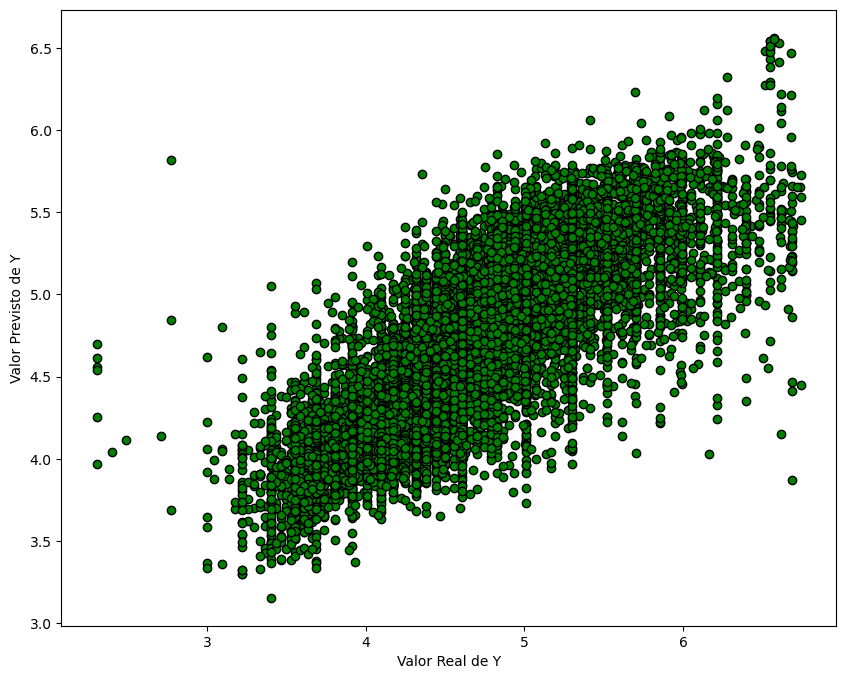

In [91]:
# Plot dos valores reais x valores previstos com Random Forest Regressor
plt.figure(figsize = (10,8))
plt.scatter(x = y_teste, y = pred_rfr, color = 'green', edgecolors = 'black')
plt.xlabel('Valor Real de Y')
plt.ylabel('Valor Previsto de Y');

In [92]:
# R²a - R quadrado ajustado
r2a_rfr = adjusted_r2(y_teste, pred_rfr, X_treino)

# MSE - Erro quadrático médio
mse_rfr = mean_squared_error(y_teste, pred_lr)

# RMSE - Raiz quadrada do erro quadrático médio
rmse_rfr = np.exp(np.sqrt(mean_squared_error(y_teste, pred_rfr)))

# # mape - Erro Percentual Absoluto Médio 
mape_rfr = np.mean(np.abs((y_teste - pred_lr) / y_teste)) * 100

In [93]:
medidas_rfr = pd.DataFrame([r2a_rfr, mse_rfr, rmse_rfr, mape_rfr], columns = ['Random Forest Regressor'], index = ['R²a', 'MSE', 'RMSE', 'MAPE'])
medidas_rfr

Random Forest Regressor
R²a                  0.646976
MSE                  0.200935
RMSE                 1.481452
MAPE                 7.304280

**Resultado dos dois modelos criados**

In [94]:
pd.concat([medidas_lr, medidas_rfr], axis = 1)

Linear Regression  Random Forest Regressor
R²a            0.540776                 0.646976
MSE            0.200935                 0.200935
RMSE           1.565582                 1.481452
MAPE           7.304280                 7.304280

Os modelos criados resultaram em valores semelhantes na maior parte das métricas de performance avaliadas, entretanto o modelo de previsão de preços com Random Forest Regressor apresentou um R² ajustado próximo de 0,6 (em torno de 20% melhor que o modelo de regressão linear). Isso significa que cerca de 60% da variabilidade nos dados é explicada pelas variáveis independentes incluídas no modelo. Embora esse valor indique uma capacidade moderada de explicar os dados, ainda há espaço para melhorias.  
Além disso, os modelos apresentam as métricas de acurácia (MSE, RMSE e MAPE) baixas, o que sugere que suas previsões estão próximas dos valores reais, indicando uma boa precisão. 

0
room_type_Entire home/apt       0.223375
longitude                       0.154688
room_type_Private room          0.130950
latitude                        0.128614
availability_365                0.070097
reviews_per_month               0.055795
number_of_reviews               0.046123
minimum_nights                  0.045919
neighborhood                    0.041792
borough_Manhattan               0.037748
calculated_host_listings_count  0.032258
room_type_Shared room           0.014943
borough_Queens                  0.008199
borough_Brooklyn                0.007320
borough_Bronx                   0.001460
borough_Staten Island           0.000718

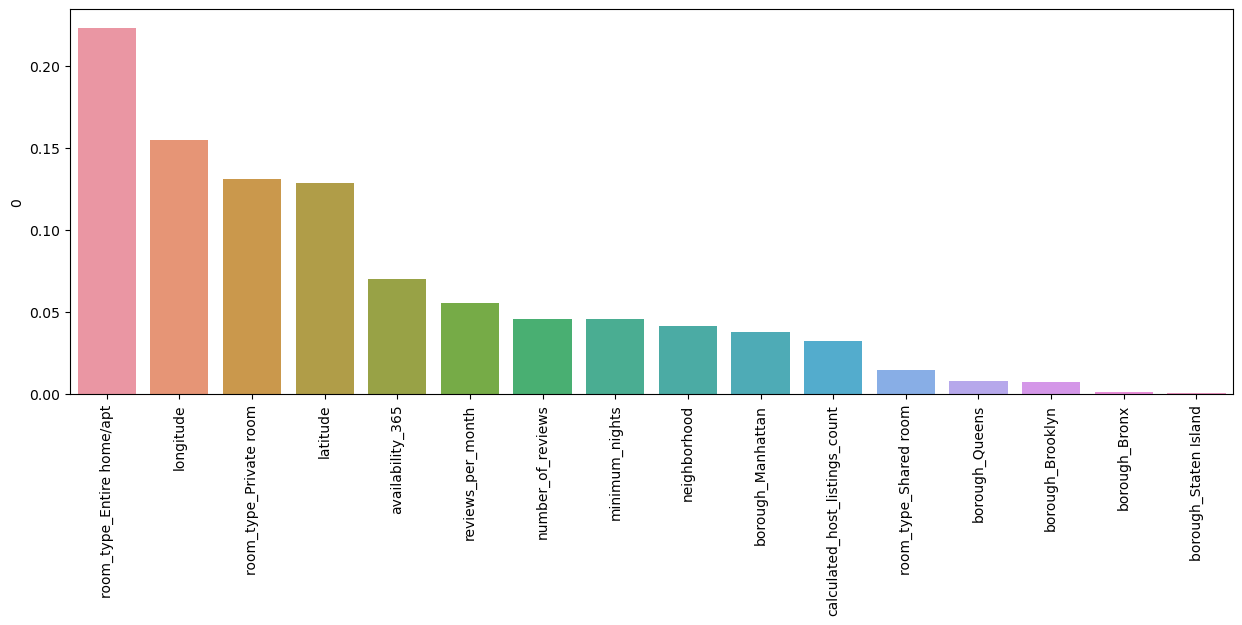

In [95]:
# Verificando a importância das features no modelo de Random Forrest Regressor
importancia_features = pd.DataFrame(modelo_rfr.feature_importances_, X_treino.columns)
importancia_features = importancia_features.sort_values(by = 0, ascending = False)

display(importancia_features)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x = importancia_features.index, y = importancia_features[0])
ax.tick_params(axis = 'x', rotation = 90)

Em nosso modelo as variáveis independes que demonstraram maior impacto na previsão de preços estão relacionadas ao tipo de acomodação, a localização (latitude e longitude) e a disponibilidade da acomodação. A exclusão de variáveis com pouco impacto do treinamento do modelo pode ser uma estratégia para melhoria de performance do modelo gerado.  
Quando uma variável tem pouco impacto significativo na previsão do modelo, sua inclusão pode adicionar complexidade desnecessária, sem melhorar sua capacidade de previsão. Isso pode levar a um sobreajuste (overfitting), onde o modelo se ajusta muito bem aos dados de treinamento, mas tem uma performance pior ao prever novos dados.
Ao remover variáveis com pouco impacto, o modelo pode se tornar mais simples e mais fácil de interpretar, ao mesmo tempo em que mantém ou até melhora sua capacidade de previsão.

**<span style="color:red">4.	Supondo um apartamento com as seguintes características:**</span>

In [96]:
dado_previsao

id                   name  host_id host_name    borough neighborhood  \
0  2595  Skylit Midtown Castle     2845  Jennifer  Manhattan      Midtown   

   latitude  longitude        room_type  price  minimum_nights  \
0  40.75362  -73.98377  Entire home/apt    225               1   

   number_of_reviews last_review  reviews_per_month  \
0                 45  2019-05-21               0.38   

   calculated_host_listings_count  availability_365  
0                               2               355

**Qual seria sua previsão de preço?**

In [97]:
# Vamos armazenar o valor que queremos prever em uma variável antes de modificar o dataframe
preco = dado_previsao['price']
preco

0    225
Name: price, dtype: int64

In [98]:
# Vamos tratar os dados da mesma forma que o conjunto de dados que treinamos o modelo
# Remoção de colunas
dado_previsao.drop(['id', 'name', 'host_id', 'host_name', 'price', 'last_review', 'borough'], axis = 1, inplace = True)

In [99]:
# One hot encoding
dado_previsao[['room_type_Entire home/apt',
               'room_type_Private room', 
               'room_type_Shared room', 
               'borough_Bronx', 
               'borough_Brooklyn', 
               'borough_Manhattan', 
               'borough_Queens',
               'borough_Staten Island']] = [1, 0, 0, 0, 0, 1, 0, 0]

In [100]:
# Label encoding
dado_previsao['neighborhood'] = label_encoder.transform(dado_previsao['neighborhood'])

In [101]:
# Normalização Standard Scaler
dado_previsao[['number_of_reviews', 'calculated_host_listings_count', 'availability_365']] = scaler.transform(dado_previsao[['number_of_reviews', 'calculated_host_listings_count', 'availability_365']])

In [102]:
df_features.columns

Index(['latitude', 'longitude', 'minimum_nights', 'reviews_per_month',
       'number_of_reviews', 'calculated_host_listings_count',
       'availability_365', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room', 'borough_Bronx',
       'borough_Brooklyn', 'borough_Manhattan', 'borough_Queens',
       'borough_Staten Island', 'neighborhood'],
      dtype='object')

In [103]:
# Reordenando as colunas
dado_previsao = dado_previsao[['latitude', 'longitude', 'minimum_nights', 'reviews_per_month', 'number_of_reviews', 
                               'calculated_host_listings_count', 'availability_365', 'room_type_Entire home/apt',
                               'room_type_Private room', 'room_type_Shared room', 'borough_Bronx', 'borough_Brooklyn', 
                               'borough_Manhattan', 'borough_Queens',
                               'borough_Staten Island', 'neighborhood']]

In [104]:
# Visualizando o registro dos dados para previsão após o tratamento
dado_previsao

latitude  longitude  minimum_nights  reviews_per_month  number_of_reviews  \
0  40.75362  -73.98377               1               0.38           0.477699   

   calculated_host_listings_count  availability_365  \
0                       -0.156005           1.86251   

   room_type_Entire home/apt  room_type_Private room  room_type_Shared room  \
0                          1                       0                      0   

   borough_Bronx  borough_Brooklyn  borough_Manhattan  borough_Queens  \
0              0                 0                  1               0   

   borough_Staten Island  neighborhood  
0                      0           127

In [105]:
# Iremos fazer a previsão utilizando o modelo de Random Forest Regressor
# Como o modelo foi treinado para prever dados logaritmicamente, convertemos os dados novamente utilizando o função np.exp()
pred_dado = np.exp(modelo_rfr.predict(dado_previsao))

print('O valor previsto foi de US$ {:.2f}, e o valor real é de US$ {:.2f}.'.format(float(pred_dado), preco[0]))

O valor previsto foi de US$ 308.56, e o valor real é de US$ 225.00.


**Salvando o modelo criado em formato .pkl**

In [106]:
# salvando o modelo Random Forest Regressor como arquivo pickle
with open('modelo_rfr_file.pkl', 'wb') as file: 
    pickle.dump(modelo_rfr, file)